# 0. Prerequisite Packages

In [67]:
!pip install torch==1.11 snntorch pandas sortedcontainers librosa numpy seaborn --extra-index-url https://download.pytorch.org/whl/cu113

import math
import glob
import os
import json
from datetime import datetime

from sortedcontainers import SortedKeyList
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import snntorch as snn
import snntorch.utils as utils
import librosa as lr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import snntorch.functional as SF
import snntorch.backprop as BP
import snntorch as snn
from snntorch import surrogate

from IPython.display import Audio, HTML, clear_output
from ipywidgets import Output
from tqdm.notebook import trange, tqdm

import cv2

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python3 -m pip install --upgrade pip


# 1. The continuous Mel Frequency Container

This is a layer taken directly from [the notebook implementing a fixed amplitude spike](VolumeAgnostic.ipynb). It takes a batch of raw frequency data in the shape $[C, S]$ where $C$ is the batch size and $S$ is the raw sample data. The output will be in the form $[C, F, A]$ where $F$ is a fixed number of frequencies based on the sample rate of the model (input signals will be resampled to the Model's Sample Rate if necessary). $A$ will be a variable length that is dependent on the shape of S in conjunction with prior calls. Input that doesn't match a the STFT window size will be buffered internally in the model.

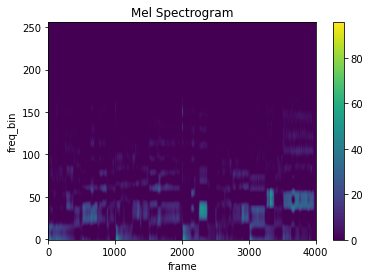

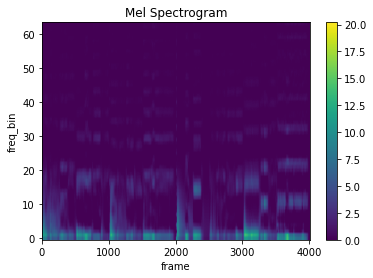

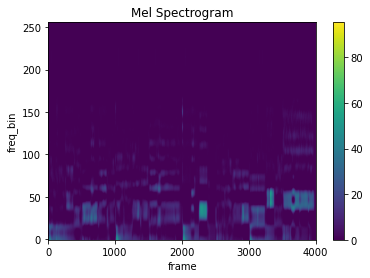

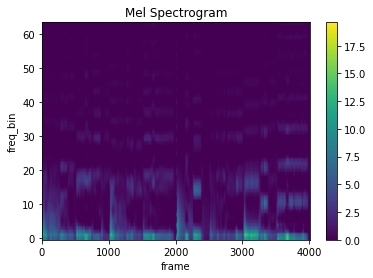

In [27]:

class ContinuousMelScale(object):
    n_mels = 256
    
    @staticmethod
    def _build_flat_convolve_kernel(total_size, kernel_size, weight_function = None):
        if not kernel_size % 2:
            raise ValueError("Kernel must be an odd number")

        result = torch.zeros((total_size, total_size), dtype=torch.float32)
        kernel_half = torch.linspace(0, 1, int((kernel_size - 1) / 2) + 1, dtype=torch.float32)[1:]
        left_kernel = kernel_half
        right_kernel = torch.flip(kernel_half, dims=(0,))
        if weight_function is not None:
            left_kernel = weight_function(left_kernel)
            right_kernel = weight_function(right_kernel)

        left_kernel *= -1
        right_kernel *= -1

        for y in range(total_size):
            left_size = min(len(left_kernel), y)
            right_size = min(len(right_kernel), total_size - (y + 1))

            left_sum = torch.sum(left_kernel[len(left_kernel) - left_size:])
            right_sum = torch.sum(right_kernel[:right_size])

            result[y, y] = 1 - (left_sum + right_sum)
            result[y, y - left_size:y] = left_kernel[len(left_kernel) - left_size:]
            result[y, y+1:y + 1 + right_size] = right_kernel[:right_size]

        return result
    
    def __init__(self, sr=44100):
        super().__init__()
        
        # the sample rate to use for the audio
        self._sr = sr
        self._resamplers = {}
        self._buffer = None
        self._unused = 0
        self._conv = ContinuousMelScale._build_flat_convolve_kernel(ContinuousMelScale.n_mels, 49, lambda x: torch.sin(x * math.pi * 2))

        self._n_fft = int(self._sr / 2)
        self._window_shift = int(self._sr / 500)
        
        self._mspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=self._sr,
            n_fft=self._n_fft,
            win_length=self._window_shift * 6,
            hop_length=self._window_shift,
            window_fn=torch.blackman_window,
            n_mels=ContinuousMelScale.n_mels,
            power=1,
            normalized=True,
            f_max=20000)
        
        self._n_mfcc = int(ContinuousMelScale.n_mels / 4)
        self._dct_mat = torchaudio.functional.create_dct(self._n_mfcc, ContinuousMelScale.n_mels, 'ortho')
        
    @property
    def output_size(self):
        return self._n_mfcc + ContinuousMelScale.n_mels
        
    def reset(self):
        self._unused = 0
        self._buffer = None
        
    def __call__(self, x, sr=None, final=False):
        if sr is None:
            sr = self._sr
            
        # resample the audio if it doesn't match
        # the sample rate
        if sr != self._sr:
            if not sr in self._resamplers:
                self._resamplers[sr] = torchaudio.transforms.Resample(
                    orig_freq=sr, 
                    new_freq=self._sr)
                
            # use round to get the correct resampled
            # size - since the resample will generate a whole
            # sample for a partial, even if it's 0.0001
            size = round((x.shape[-1] / sr) * self._sr)
            x = self._resamplers[sr](x)
            x = x[..., :size]
         
        # we first incorporate the buffer
        # into the signal. The buffer will carry
        # extra signal which we didn't evaluate from
        # the previous run
        origsize = x.shape[-1] + self._unused
        if self._buffer is not None:
            x = torch.concat((self._buffer, x), dim=len(x.shape) - 1)
        
        # align the sample to the high frequency window. If there are extra
        # we will include them in the buffer
        keep = origsize % (self._window_shift * 2)
        self._unused = keep
        if keep:
            # if this is the final block, just pad with zeros, otherwise let the rest
            # go to the buffer
            if final:
                extra = (self._window_shift * 2) - keep
                x1 = F.pad(x, (0, extra), value=0)
                origsize += extra
            else:
                x1 = x[..., :-keep]
                origsize -= keep
        else:
            x1 = x
      
        # keep the last low size buffer
        skip_samples = x1.shape[-1] - origsize
        skip_size = int(skip_samples / self._window_shift)
        
        if x1.shape[-1] < self._n_fft:
            mel = torch.zeros(list(x1.shape[:-1]) + [ContinuousMelScale.n_mels + self._n_mfcc, 0], device=x.device).transpose(-2, -1)
            self._buffer = x
            self._unused = origsize
        else:
            mel = self._mspec(x1)[..., :-1] * (ContinuousMelScale.n_mels / 1024)
            mel = mel[..., skip_size:-1]
            
            mfcc = torch.log(mel + 1e-6)
            mfcc = torch.relu(torch.matmul(mel.transpose(-1, -2), self._dct_mat))
            
            mel = torch.matmul(mel.transpose(-1, -2), self._conv)
            mel = torch.cat((mel, mfcc), dim=-1)

            keep = min(self._n_fft, x.shape[-1])
            self._buffer = x[..., -keep:]
            
        self._unused += self._window_shift
        return torch.relu(mel).transpose(-2, -1)


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(spec[..., :ContinuousMelScale.n_mels, :], origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'MFCC')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(spec[..., ContinuousMelScale.n_mels:, :], origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
audio, sr = lr.load('scores/audited/10.wav', sr=22050)
audio = torch.unsqueeze(torch.tensor(audio), 0)

model = ContinuousMelScale()

with torch.no_grad():
    spec = model(torch.cat([audio, audio]), sr, True)
    plot_spectrogram(spec[0], 'Mel Spectrogram')
    
with torch.no_grad():
    model.reset()
    signal = torch.zeros((1, int(ContinuousMelScale.n_mels * 1.25), 0))
    for i in range(0, audio.shape[1], 2205):
        spec = model(audio[:, i:i+2205], sr, i + 2205 >= audio.shape[1])
        signal = torch.concat((signal, spec), dim=2)
        
    plot_spectrogram(signal[0], 'Mel Spectrogram')
    
Audio(audio, rate=sr)

# 2. Volume Normalised Spike Train Layer

This layer is also taken directly from [the same notebook as above](VolumeAgnostic.ipynb). It takes the 
output of the continuous mel layer and produces a spike train representation of the Mel Spectrum data over time, spiking more frequently for higher amplitudes and less frequently for lower ones, to a minimum threshold.

torch.Size([176400])
torch.Size([320, 4008])
torch.Size([320, 4008])


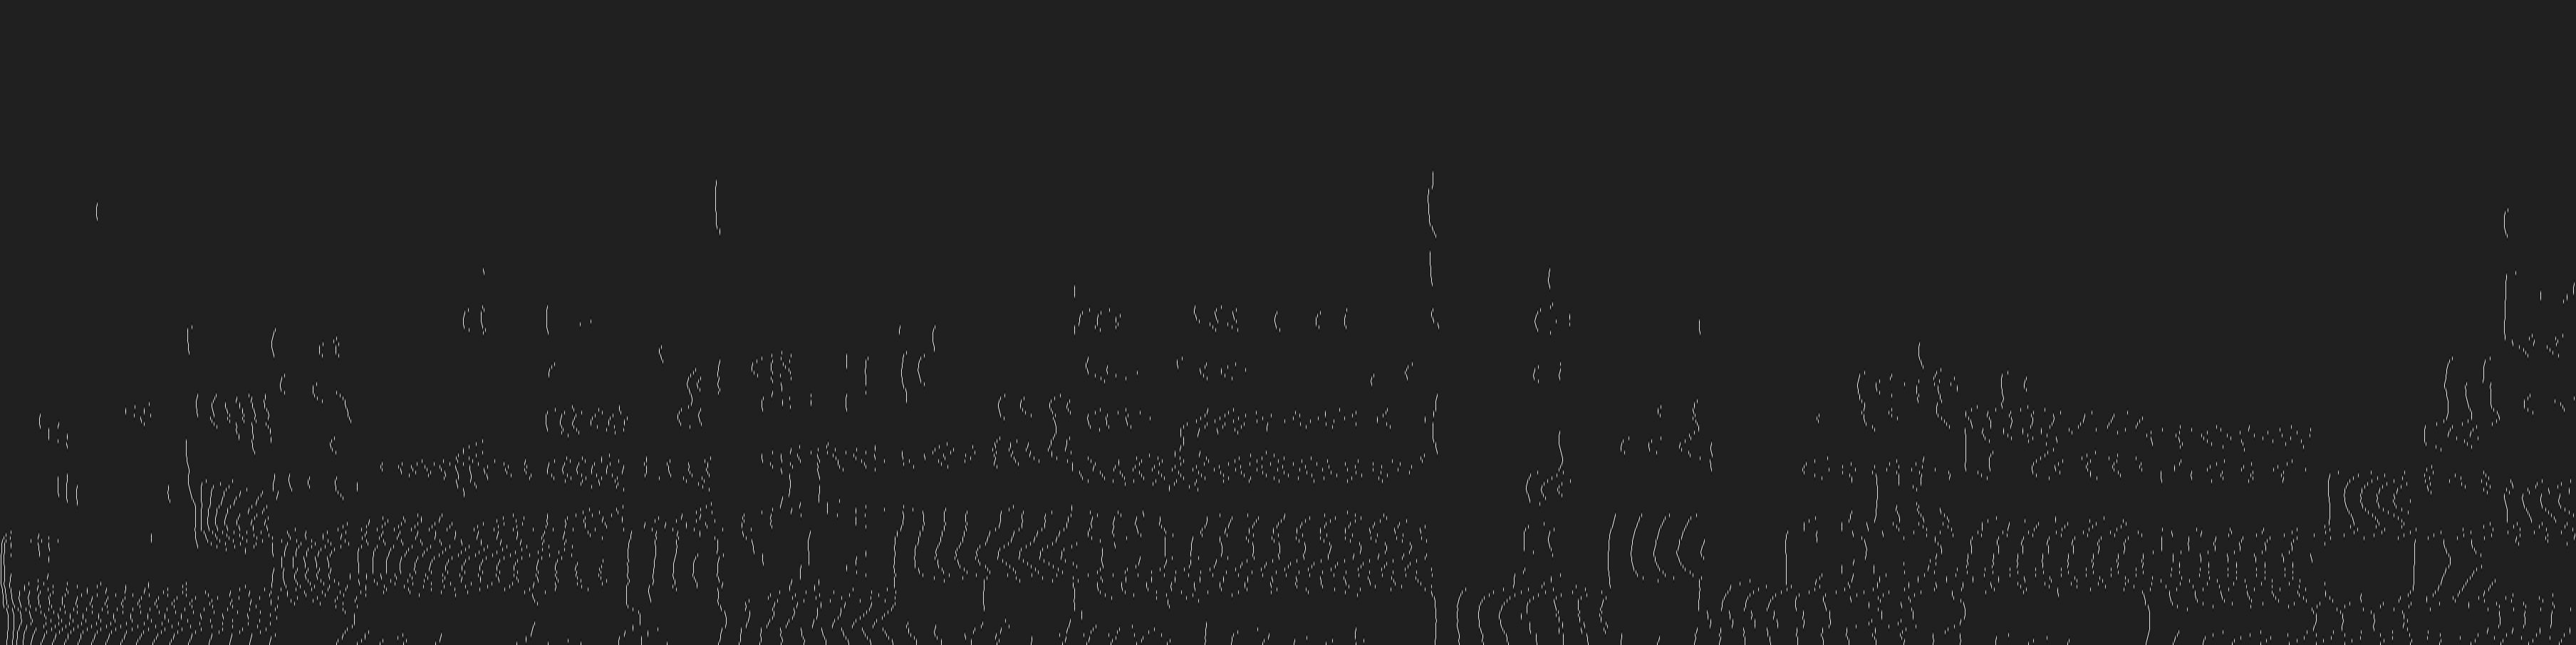

In [83]:

class FixedThresholdSpikeLayer(nn.Module):
    
    def __init__(self, alpha = 1.0, surrogate_slope = 4, minimum_absolute_amplitude = 0.25):
        super().__init__()
        self.minimum_absolute_amplitude = minimum_absolute_amplitude
        self._spikes = snn.Synaptic(
            beta=0.850854,
            alpha=alpha,
            learn_beta=False,
            learn_threshold=False,
            learn_alpha=True,
            spike_grad=surrogate.fast_sigmoid(surrogate_slope),
            threshold=1,
            reset_mechanism='zero',
            init_hidden=True)
    
    def checkpoint(self):
        decaydata = self._spikes.mem.data
        decaysyn = self._spikes.syn.data
        
        self._spikes.syn, self._spikes.mem = self._spikes.init_synaptic()
        self._spikes.mem.data = decaydata
        self._spikes.syn.data = decaysyn
             
    
    def forward(self, x):
        # normalise x
        minx, _ = torch.min(x, -1)
        maxx, _ = torch.max(x, -1)
        
        minvalue = self.minimum_absolute_amplitude * 2
        
        xrange = (torch.relu((maxx - minx) - minvalue) + minvalue).unsqueeze(-1)
        x /= xrange
        
        return self._spikes(x)
        
    def reset(self):
        utils.reset(self)

def plot_only_spiked(data, title):
    
        
def plot_spike_train(data, title, sr=44100):
    melspec_layer = ContinuousMelScale(sr=sr)
    spike_layer = FixedThresholdSpikeLayer()
    
    spike_layer.eval()
    
    with torch.no_grad():
        melspec_layer.reset()
        spike_layer.reset()
        
        spike_layer.checkpoint()
        print(data.shape)
        data = melspec_layer(data.unsqueeze(0), sr=sr, final=True)[0]
        print(data.shape)
        
        for i in range(data.shape[-1]):
            data[..., i] = spike_layer(data[..., i])
    
    fig, ax = plt.subplots(figsize=(64, 16))
        
    print(data.shape)
    img = cv2.resize(data.detach().numpy() * 255, dsize=(data.shape[1], 1280), interpolation=cv2.INTER_CUBIC)
    fig.figimage(img, cmap='gray', origin='lower')
    fig.figimage(img, cmap='gray', origin='lower')
    plt.show()
    
plot_spike_train(audio[0], 'Audio Sample', sr)

# 3. The Goldilocks Neuron

This is taken from the [notebook that defined and implemented the Goldilocks architecture](TemporalPatterns.ipynb). It defines a layer that expects as input individual spikes and spikes only if only if the incoming spike train is temporally within the "Goldilocks" threshold. This is slightly modified from the notebook to handle an extra dimension of input.

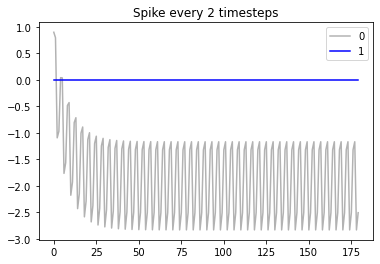

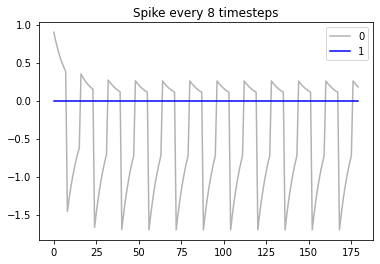

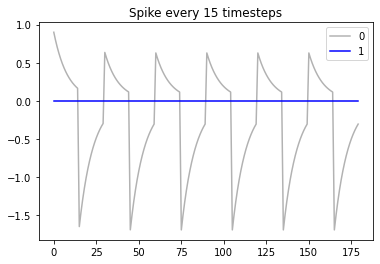

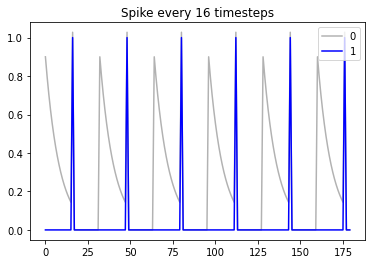

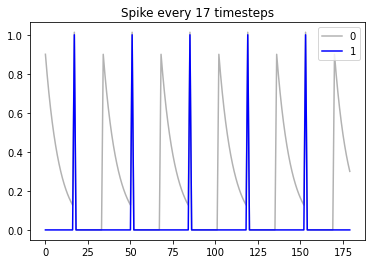

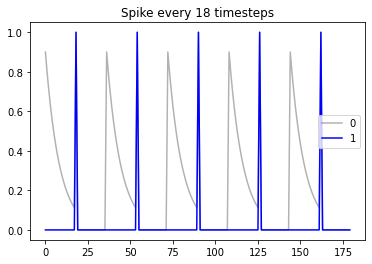

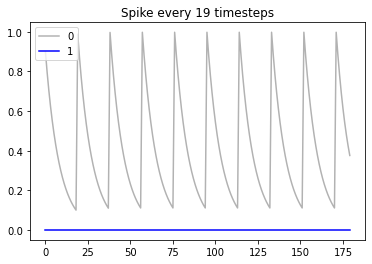

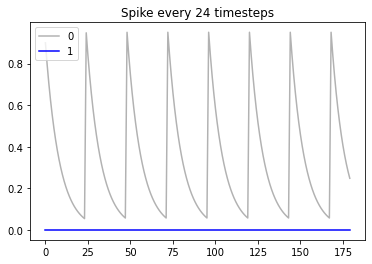

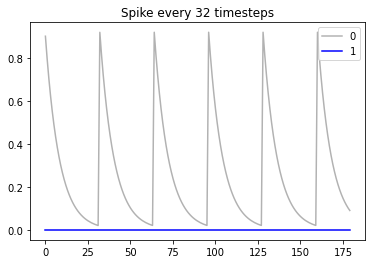

In [4]:

class LeakyTemporal(nn.Module):
    
    def __init__(self, beta_theta, w_theta, beta_tau, w_tau = None, learn_w_theta = False, learn_w_tau = False, surrogate_slope=8):
        super().__init__()
        
        if w_tau is None:
            w_tau = 2.
        
        self.w_theta = torch.nn.Parameter(torch.as_tensor(w_theta), requires_grad=learn_w_theta)
        self.w_tau = torch.nn.Parameter(torch.as_tensor(w_tau), requires_grad=learn_w_tau)
        
        self._inhibit = snn.Leaky(
            beta=beta_tau,
            learn_beta=True,
            learn_threshold=False,
            threshold=1.,
            spike_grad=surrogate.fast_sigmoid(slope=surrogate_slope),
            reset_mechanism='zero')
        self._inmem = self._inhibit.init_leaky()
        
        self.beta_tau = self._inhibit.beta
        
        self._fire = snn.Leaky(
            beta=beta_theta,
            learn_beta=True,
            learn_threshold=False,
            threshold=1.,
            spike_grad=surrogate.fast_sigmoid(slope=surrogate_slope),
            reset_mechanism='zero')
        self._mem = self._fire.init_leaky()

        self.beta_theta = self._fire.beta
        
    def checkpoint(self):
        fdata = self._mem.data
        idata = self._inmem.data
        
        self.reset()
        self._mem.data = fdata
        self._inmem.data = idata
        
    def reset(self):
        self._mem = self._fire.init_leaky()
        self._inmem = self._inhibit.init_leaky()

    def forward(self, x):
        inhibition, self._inmem = self._inhibit(x * self.w_theta, self._inmem)
        inhibition = (inhibition * -2) + 1
        
        cm, mm = self._fire(x * inhibition * self.w_theta, self._mem)

        inhibit_tau = torch.relu(-inhibition).detach() * self.w_tau
        mm = mm - inhibit_tau
        self._mem = mm
        
        return cm, mm

        
def model_every_n(n, width=180):
    out = np.zeros((len(n), width))
    mem = np.zeros((len(n), width))
    
    emodel = LeakyTemporal(
        beta_theta=torch.full((len(n),), 0.88509), 
        w_theta=torch.full((len(n),), 0.9), 
        beta_tau=torch.full((len(n),), 0.86375),
        w_tau=torch.full((len(n),), 0.9))
    emodel.eval()
    
    n_input = torch.zeros((len(n), width))
    for i, freq in enumerate(n):
        ix_len = math.ceil(width / freq)
        trim = (width % freq)
        if not trim:
            trim = (freq - trim)
        indices = torch.linspace(0, width - trim, ix_len, dtype=int)
        n_input[i, indices] = 1.

    with torch.no_grad():
        
        out = None
        mem = None
        
        n_input = n_input.unsqueeze(0)
        for i in range(n_input.shape[-1]):
            xi = n_input[..., i]
            
            cm, mm = emodel(xi)
            
            if i == 0:
                out = cm.unsqueeze(-1)
                mem = mm.unsqueeze(-1)
            else:
                out = torch.concat((out, cm.unsqueeze(-1)), dim=-1)
                mem = torch.concat((mem, mm.unsqueeze(-1)), dim=-1)
            
        
    out = np.array([mem[0].detach().numpy(), out[0].detach().numpy()])
    for i, freq in enumerate(n):
        sns.lineplot(data = out[:, i, :].transpose(1, 0),
                     palette = [(0, 0, 0, 0.3), 'blue'],
                     dashes=False).set(title=f'Spike every {freq} timesteps')
        plt.show()

model_every_n([2, 8, 15, 16, 17, 18, 19, 24, 32])

# 4. Final Model

At this stage, I can build out the model and start comparing it to the baseline on the pure audio in the NSynth dataset in [the baseline notebook](MFCC.ipynb). I will do that here and will leave room to pass in alternate hyperparameters along the way.


torch.Size([1, 176400])
starting at 2022-09-03 04:20:01.874


/home/karagon/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (5513) may be set too low.
  warnings.warn(


finished at 2022-09-03 04:20:04.309
torch.Size([1, 1, 4008])


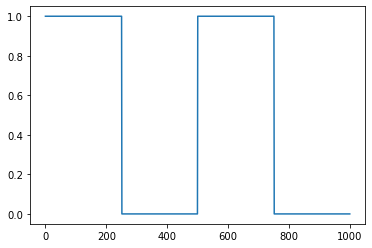

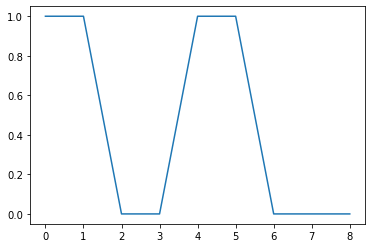

In [5]:

class AudioIdentificationModel(nn.Module):
    
    def _inference_output(self, xi):
        xi, mem = self._output_beta(xi, self._output_membrane)
        mem = torch.clamp(mem, 0, 0.9)
        self._output_membrane = mem
        
        return xi
    
    def __init__(
        self,
        output_classes,
        sr=44100,
        convolution_kernel_size = 41,
        convolution_count = 4,
        instant_hidden_layer_size = 1024,
        intermediate_hidden_layer_size = 128,
        spike_window_milliseconds = 500,
        minimum_absolute_amplitude = 0.025,
        initial_spike_surrogate_slope = 2,
        instant_surrogate_slope = 20,
        output_spike_slope = 2):
        
        # base init
        super().__init__()
        
        self.pooling_window_milliseconds = spike_window_milliseconds
        
        # define the mel spectrogram layer
        self._melspectrogram = ContinuousMelScale(sr=sr)
        
        # define the input spike layer
        self._input_spike = FixedThresholdSpikeLayer(
            alpha=torch.full((self._melspectrogram.output_size,), 1.0),
            surrogate_slope=initial_spike_surrogate_slope,
            minimum_absolute_amplitude=minimum_absolute_amplitude)
        
        # define the input convolution
        self._input_conv1d = nn.Conv1d(
            in_channels=1, 
            out_channels=convolution_count,
            padding='same',
            kernel_size=convolution_kernel_size)
        
        convolution_size = self._melspectrogram.output_size * convolution_count
        
        # define the dense connection reducing the
        # instantaneous spike train to a reduced spike train.
        # This layer won't have bias. It's role is to accumulate
        # meaningful spikes on the convolution layer
        self._instant_hidden = nn.Linear(
            convolution_size, 
            instant_hidden_layer_size)
        
        # define the instantaneous goldilocks layer
        self._instant_gsnn = LeakyTemporal(
            beta_theta = torch.full((instant_hidden_layer_size,), 0.5),
            w_theta = torch.full((instant_hidden_layer_size,), 0.9),
            beta_tau = torch.full((instant_hidden_layer_size,), 0.4),
            learn_w_tau = False,
            learn_w_theta = True,
            surrogate_slope = instant_surrogate_slope)
        
        # and a layer that we will use the membrane potential of
        # based on fires of the goldilocks membrane
        self._instant_decay = snn.Leaky(
            beta=torch.full((instant_hidden_layer_size,), 0.85),
            learn_beta=True,
            learn_threshold=False,
            threshold=1-1e-7,
            reset_mechanism='none',
            spike_grad=surrogate.fast_sigmoid(instant_surrogate_slope),
            init_hidden=True,
            output=True)
        
        # another one to capture important relationships by 
        # the dense layer above
        self._intermediate_hidden = nn.Linear(
            instant_hidden_layer_size, 
            intermediate_hidden_layer_size)

        # define the output spikes that will feed into the output
        # Pooling/Spiking layer
        self._output_hidden = nn.Linear(
            intermediate_hidden_layer_size,
            output_classes)
        
        self._output_size = output_classes
        
        # define a layer that converts the reduced sigmoid to a spike train
        self._output_spike = snn.Leaky(
            beta=0,
            learn_beta=False,
            learn_threshold=False,
            threshold=0.5,
            reset_mechanism='zero',
            spike_grad=surrogate.fast_sigmoid(output_spike_slope))
        
        # calculate the beta for our output layer that will die off
        # after the given number of milliseconds. each sample represents 2
        # milliseconds. So the times steps in the window are the ms / 2
        spike_window_timesteps = spike_window_milliseconds / 2
        
        # based on those timesteps, we define our max pool window using the
        self._train_pool = nn.MaxPool1d(
            math.ceil(spike_window_timesteps), 
            stride = int(spike_window_timesteps / 2),
            padding = int(spike_window_timesteps / 2))
        
        # our threshold will be 0.1. So after a spike, at 1.0, our threshold
        # will be reduced to 0.9. We want that to stay above 0.1 for our spike
        # window - so we say:
        # 
        # $0.9\beta^t >= 0.1$
        # $\beta^t >= 1/9$
        # $\beta = (1/9)^\frac{1}{t}#
        output_beta = (1. / 9.)**(1. / spike_window_timesteps)

        # with that, intialize our layer that will preserve spikes when
        # in inference mode through time
        self._output_beta = snn.Leaky(
            beta=output_beta,
            learn_beta=False,
            learn_threshold=False,
            threshold=0.1,
            reset_mechanism='none',
            spike_grad=surrogate.fast_sigmoid(output_spike_slope))
        
        self._output_membrane = self._output_beta.init_leaky()
        
        
    def reset(self):
        # default snn reset
        utils.reset(self)
        
        # reset the mel spectogram
        self._melspectrogram.reset()
        
        # reset the input spike
        self._input_spike.reset()
        
        # reset the instantaneous gsnn
        self._instant_gsnn.reset()
        
    def checkpoint(self):
        decaydata = self._instant_decay.mem.data
        self._instant_decay.mem = self._instant_decay.init_leaky()
        self._instant_decay.data = decaydata
                
        self._input_spike.checkpoint()
            
        self._instant_gsnn.checkpoint()
        
        
    def forward(self, x, sr=None, final_sample=False):
        
        # if we got only a single sample, unsqeeze it for a batch of 1
        if len(x.shape) != 2:
            if len(x.shape) == 1:
                x = x.unsqueeze(0)
            else:
                raise ValueError('Expected either a single auto sample (N) or a batch of audio samples (B, N)')
                
        # convert to the mel spectrum... do this on the cpu because
        # there's some out of memory bug in the torchaudio impl: 
        xdevice = next(self._output_hidden.parameters()).device
        with torch.no_grad():
            x = self._melspectrogram(x.cpu(), sr, final_sample).detach().to(xdevice)
            
        # define the unpooled result
        osz = list(x.shape)
        osz[-2] = self._output_size
        result = torch.zeros(tuple(osz), device=xdevice)
        
        # Now we do per-timestep operations
        for i in range(x.shape[-1]):
            xi = x[..., i]
            
            # threshold the magnitude
            xi = self._input_spike(xi)
            
            # convolve the incoming spike train and sigmoid it
            xi = self._input_conv1d(xi.unsqueeze(-2))
            xi = torch.flatten(xi, start_dim=-2)
            xi = torch.relu(xi)

            # get the reduced instant mapping 
            xi = self._instant_hidden(xi)
            xi = torch.sigmoid(xi)
            
            # apply the instantaneous goldilocks
            xi, _ = self._instant_gsnn(xi)
            
            # and use the membrane potential of our instant decay snn
            _, instant_decayed = self._instant_decay(xi)
            xi = torch.sigmoid(instant_decayed)
            
            # and the intermediate
            xi = self._intermediate_hidden(xi)
            xi = torch.relu(xi)

            # reduce that to the output
            xi = self._output_hidden(xi)
            xi = torch.sigmoid(xi)
            
            # convert that to an output spike
            xi, _ = self._output_spike(xi, torch.zeros(xi.shape, device=xdevice))
            
            # if we're not training apply the beta to preserve spikes on a
            # sample by sample basis for the window
            if not self.training:
                xi = self._inference_output(xi)
            
            # reshape the sample result
            result[..., i] = xi
                
        # if we are training run the max pool over the result to pick off spikes
        # in the time window
        if self.training:
            result = self._train_pool(result)
                
        # result is a list of spikes 
        return result

print(audio.shape)
model = AudioIdentificationModel(1, sr=22050)

# benchmark running the model on our audio sample to make sure
# we can keep up with real time.
with torch.no_grad():
    model.reset()
    model.eval()
    
    print(f'starting at {datetime.now().isoformat(sep=" ", timespec="milliseconds")}')
    y = model(audio, final_sample=True)
    print(f'finished at {datetime.now().isoformat(sep=" ", timespec="milliseconds")}')
    print(y.shape)

# make sure the beta_output layer works as expected
beta_spike_input = torch.zeros((1, 1))

# we expect the spike to last about 250 samples
with torch.no_grad():
    model.reset()
    beta_spike_output = torch.zeros((1000,))

    for i in range(beta_spike_output.shape[0]):
        if (i % 500) == 0:
            model.checkpoint()
            beta_spike_input.fill_(1)
        else:
            beta_spike_input.fill_(0)

        beta_spike_output[i] = model._inference_output(beta_spike_input)
        
    sns.lineplot(data = beta_spike_output)
    plt.show()
    
# the window should produce a similar result
with torch.no_grad():
    model.reset()
    
    beta_spike_input = torch.zeros((1, 1000))
    beta_spike_input[0, 0] = 1
    beta_spike_input[0, 500] = 1
    
    beta_spike_output = model._train_pool(beta_spike_input)[0]
    sns.lineplot(data = beta_spike_output.cpu())
    plt.show()


## 4.1 Comparison data set 
We will reuse the methods from the [baseline notebook](MFCC.ipynb) to build and train the model on the same data we started with. Then we can establish whether we've established a better model. After that's been established, we will switch gears to the real noisy data set. But we'll want this to be reusable for the next case, so we'll build it out with the proper mechanisms that we can use it to train and test with our noisy data as well.

Batch
* File
    * Onset
       * Start Time
       * End Time
       * Instrument (Family)
       * Source
       * Pitch
    * Onset
       * ...
       
The data loader will need to load the audio file as the input sample. Then it can generate a linear set of the labels within timing information as a 0 to 1 value. The training and validation process can then scale those as needed to build the labels for the use case by converting the input samples to a scalar relative to the total number of samples that are available. That would be the real time approach. The train/test approach will just be to scale them against the collection of output labels

### 4.1.1 Reading the nsynth dataset as-is

In [6]:
# Read the nsynth json to get an index
def read_nsynth_json(json_file):
    result = []
    directory = os.path.dirname(json_file)
    with open(json_file, 'r') as f:
        jobj = json.load(f)
        for key, obj in tqdm(jobj.items(), desc=f'Loading file {json_file}'):
            filename = os.path.join(directory, 'audio', key + '.wav')
            obj['filename'] = filename
            
            audio = lr.load(filename, sr=obj['sample_rate'])[0]
            start_sample = np.argmax(audio > 0.1)
            end_sample = len(audio) - (np.argmax(np.flip(audio)-1) > 0.1)
            
            obj['start_time'] = start_sample / obj['sample_rate']
            obj['end_time'] = end_sample / obj['sample_rate']
            obj['total_time'] = len(audio) / obj['sample_rate']
            result.append(obj)
            
    return pd.DataFrame(result)
        
if os.path.exists('cache/nsynth-valid.csv'):
    nsynth_valid = pd.read_csv('cache/nsynth-valid.csv')
else:
    nsynth_valid = read_nsynth_json('data/nsynth-valid/examples.json')
    nsynth_valid.to_csv('cache/nsynth-valid.csv')
    
if os.path.exists('cache/nsynth-test.csv'):
    nsynth_test = pd.read_csv('cache/nsynth-test.csv')
else:
    nsynth_test = read_nsynth_json('data/nsynth-test/examples.json')
    nsynth_test.to_csv('cache/nsynth-test.csv')
    
if os.path.exists('cache/nsynth-train.csv'):
    nsynth_train = pd.read_csv('cache/nsynth-train.csv')
else:
    nsynth_train = read_nsynth_json('data/nsynth-train/examples.json')
    nsynth_train.to_csv('cache/nsynth-train.csv')
    
nsynth_train

,Unnamed: 0,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities,filename,start_time,end_time,total_time
0,0,16629,16000,82,0,guitar,guitar_acoustic_001,guitar_acoustic_001-082-050,['percussive'],acoustic,50,3,39,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",data/nsynth-train/audio/guitar_acoustic_001-08...,0.013187,3.999938,4.0
1,1,168243,16000,108,2,bass,bass_synthetic_120,bass_synthetic_120-108-050,['percussive'],synthetic,50,0,881,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",data/nsynth-train/audio/bass_synthetic_120-108...,0.000063,3.999938,4.0
2,2,88495,16000,50,1,organ,organ_electronic_120,organ_electronic_120-050-127,[],electronic,127,6,979,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",data/nsynth-train/audio/organ_electronic_120-0...,0.003312,3.999938,4.0
3,3,146382,16000,26,1,guitar,guitar_electronic_021,guitar_electronic_021-026-025,"['fast_decay', 'percussive']",electronic,25,3,346,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]",data/nsynth-train/audio/guitar_electronic_021-...,0.001563,3.999938,4.0
4,4,244275,16000,79,1,organ,organ_electronic_011,organ_electronic_011-079-075,['bright'],electronic,75,6,188,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",data/nsynth-train/audio/organ_electronic_011-0...,0.001313,3.999938,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289200,289200,190815,16000,39,1,organ,organ_electronic_083,organ_electronic_083-039-100,['dark'],electronic,100,6,808,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",data/nsynth-train/audio/organ_electronic_083-0...,0.003500,3.999938,4.0
289201,289201,81228,16000,53,1,bass,bass_electronic_024,bass_electronic_024-053-025,['distortion'],electronic,25,0,847,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",data/nsynth-train/audio/bass_electronic_024-05...,0.022250,3.999938,4.0
289202,289202,20732,16000,58,0,string,string_acoustic_082,string_acoustic_082-058-100,['reverb'],acoustic,100,8,699,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",data/nsynth-train/audio/string_acoustic_082-05...,0.097000,3.999938,4.0
289203,289203,28856,16000,56,0,reed,reed_acoustic_020,reed_acoustic_020-056-100,[],acoustic,100,7,200,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",data/nsynth-train/audio/reed_acoustic_020-056-...,0.014687,3.999938,4.0


### 4.1.2 Converting the nsynth data to labels

In general, we're going to need to be able to build labels we can use to train. The way we do that is by converting an array of specifications of size N to an array of one-hot encodings of size M. Where N matches the unique sets of instruments in a sample and M matches the output size. In the nsynth loader above, we've captured where the audio begins and end as a normalised scalar with respect to the entire sample.


In [7]:
def nsynth_row_to_inst_spec(row):
    return [{
        'inst': row['instrument_family'],
        'src': row['instrument_source'],
        'start': row['start_time'] / row['total_time'],
        'end': row['end_time'] / row['end_time']
    }]


def inst_spec_to_feature_list(insts):
    # create the result
    result = SortedKeyList(key=lambda x: (x['start'] * 1000000) + x['end'])
    max_end = 0

    # the result is sorted by start first and then end.
    for ent in insts:
        ent = dict(ent)
        max_end = max(ent['end'], max_end)

        while ent['end'] > ent['start']:
            # get the index of the item with an equal
            existing_index = result.bisect_left(ent)

            # there's maybe already an existing entry
            if existing_index < len(result) and result[existing_index]['start'] == ent['start']:
                existing_ent = result[existing_index]
                feature_exists = any(
                    x['inst'] == ent['inst'] and x['src'] == ent['src'] for x in existing_ent['features'])

                # If we got to this point, we have an entry already with the same start time
                # we have an entry we either need to split
                # or merge - it has an end time >= to the current
                # entry.
                if feature_exists:
                    # this is just a nested duplicate
                    break

                # do we need to split?
                if existing_ent['end'] == ent['end']:
                    # nope - just add the instrument
                    existing_ent['features'].append({'inst': ent['inst'], 'src': ent['src']})
                    break

                # so we need to split - we'll add the instrument to the
                # current entry and adjust ent to be the part of existing
                # that we had to chop out
                new_ent = {
                    'start': ent['end'],
                    'end': existing_ent['end'],
                    'features': list(existing_ent['features'])
                }

                existing_ent['features'].append({'inst': ent['inst'], 'src': ent['src']})
                existing_ent['end'] = ent['end']
                result.add(new_ent)
                break

            # In this case, we landed on an entry that starts *after* the one we are
            # inserting. That means the following possibilities:
            # * The entry is wholly in a gap between the previous index and this one
            # * the entry starts in a gap between the previous entry but overlaps
            #       this case is only possible if index is 0. Otherwise, we've already filled the space
            # * The entry starts in the middle of the previous entry and ends *anywhere* after

            # case 1: There's no previous entry
            existing_ent = result[existing_index] if existing_index < len(result) else None
            new_end = min(ent['end'], existing_ent['start'] if existing_ent else math.inf)
            if existing_index == 0:
                if existing_ent:
                    if existing_ent['start'] > ent['end']:
                        result.add({
                            'start': ent['end'],
                            'end': existing_ent['start'],
                            'features': []
                        })

                result.add({
                    'start': ent['start'],
                    'end': new_end,
                    'features': [{'inst': ent['inst'], 'src': ent['src']}]
                })

                ent['start'] = new_end
                continue

            # There is a previous entry
            previous_ent = result[existing_index - 1]

            # case 3: The entry overlaps the previous one
            # * case 3a: The entry is actually entirely inside the previous one
            feature_exists = any(x['inst'] == ent['inst'] and x['src'] == ent['src'] for x in previous_ent['features'])
            if ent['end'] < previous_ent['end']:
                # if the feature is already there, it's just a dupe
                if feature_exists:
                    break

                # otherwise create a feature to insert on the right side
                new_ent = {
                    'start': ent['end'],
                    'end': previous_ent['end'],
                    'features': previous_ent['features']
                }

                # chop the prior end off at start
                previous_ent['end'] = ent['start']

                # insert the new overlapped feature
                result.add({
                    'start': ent['start'],
                    'end': ent['end'],
                    'features': previous_ent['features'] + [{'inst': ent['inst'], 'src': ent['src']}]
                })

                # add the one we created
                result.add(new_ent)
                break

            # * case 3b: The entry actually bleeds past the prior entry, ending either before
            #            or after the current one starts. If it already exists in the prior one,
            #            it may actually be a proper duplicate
            if feature_exists:
                if len(previous_ent['features']) == 1 and \
                        previous_ent['features'][0]['inst'] == ent['inst'] and \
                        previous_ent['features'][0]['src'] == ent['src']:
                    # it is a proper duplicate - extend existing
                    previous_ent['end'] = new_end
                    ent['start'] = new_end
                    continue

                # it's not a proper duplicate but it is already contained in the previous ent
                # fall back with the modified ent
                ent['start'] = previous_ent['end']
                continue

            # The entry did not exist - smoosh down previous and add the merge
            new_ent = {
                'start': ent['start'],
                'end': previous_ent['end'],
                'features': previous_ent['features'] + [{'inst': ent['inst'], 'src': ent['src']}]
            }

            previous_ent['end'] = ent['start']
            result.add(new_ent)
            continue

    # merge contiguous duplicates
    i = 1
    if result:
        result[0]['features'].sort(key = lambda x: x['inst'] * 100000 + x['src'])

    while i < len(result):
        pres = result[i - 1]
        res = result[i]

        res['features'].sort(key=lambda x: x['inst'] * 100000 + x['src'])
        if res['start'] == pres['end'] and len(res['features']) == len(pres['features']):
            matches = True
            for x in range(len(res['features'])):
                if res['features'][x]['inst'] != pres['features'][x]['inst'] or \
                        res['features'][x]['src'] != pres['features'][x]['src']:
                    matches = False
                    break
            if matches:
                pres['end'] = res['end']
                del result[i]
                continue

        i += 1

    result = list(result)
    for r in result:
        r['time'] = r['start']
        del r['end']
        del r['start']
    result.append({'features': [], 'time': max_end})
    return result


actual = inst_spec_to_feature_list([
    {'inst': 5, 'src': 0, 'start': 90, 'end': 95},
    {'inst': 2, 'src': 0, 'start': 60, 'end': 70},
    {'inst': 2, 'src': 0, 'start': 50, 'end': 60},
    {'inst': 2, 'src': 0, 'start': 70, 'end': 80},
    {'inst': 0, 'src': 0, 'start': 10, 'end': 60},
    {'inst': 1, 'src': 0, 'start': 10, 'end': 40},
    {'inst': 0, 'src': 0, 'start': 20, 'end': 60},
    {'inst': 3, 'src': 0, 'start': 30, 'end': 40},
    {'inst': 4, 'src': 0, 'start': 85, 'end': 89},
    {'inst': 4, 'src': 0, 'start': 87, 'end': 88},
])

expected = [
    {'features': [{'inst': 0, 'src': 0}, {'inst': 1, 'src': 0}], 'time': 10},
    {'features': [{'inst': 0, 'src': 0}, {'inst': 1, 'src': 0}, {'inst': 3, 'src': 0}], 'time': 30},
    {'features': [{'inst': 0, 'src': 0}], 'time': 40},
    {'features': [{'inst': 0, 'src': 0}, {'inst': 2, 'src': 0}], 'time': 50},
    {'features': [{'inst': 2, 'src': 0}], 'time': 60},
    {'features': [], 'time': 80},
    {'features': [{'inst': 4, 'src': 0}], 'time': 85},
    {'features': [], 'time': 89},
    {'features': [{'inst': 5, 'src': 0}], 'time': 90},
    {'features': [], 'time': 95}
]

def feature_list_to_labels(feature_list_batch, outputs, instrument_count = 11, source_count = 3):
    encodings = instrument_count * source_count
    
    batch_size = len(feature_list_batch)
    result = torch.zeros((batch_size, encodings, outputs))
    for feat_index in range(batch_size):
        time_steps = feature_list_batch[feat_index]
        
        previous_timestep = None
        for time_step_index in range(len(time_steps)):
            time_step = time_steps[time_step_index]
            if previous_timestep and previous_timestep['time'] != time_step['time']:
                start_index = int(previous_timestep['time'] * outputs)
                end_index = int(math.ceil(time_step['time'] * outputs))
                for feature in previous_timestep['features']:
                    one_hot_index = (feature['src'] * instrument_count) + feature['inst']
                    if one_hot_index >= outputs:
                        continue

                    result[feat_index, one_hot_index, start_index:end_index] = 1
                    
            previous_timestep = time_step
            
        # the extra empty element at the end of the feature list is why we don't
        # need anything special. We'll end up igoring it as desired
        
    return result

print(actual)
assert (len(expected) == len(actual))
for i in range(len(expected)):
    # make sure the timestamp matches
    assert (expected[i]['time'] == actual[i]['time'])

    # build the instruments
    actual_insts = set([f'{v["inst"]}:{v["src"]}' for v in actual[i]['features']])
    expected_insts = set([f'{v["inst"]}:{v["src"]}' for v in expected[i]['features']])
    assert (not actual_insts.difference(expected_insts))

features = nsynth_valid[10:20].apply(nsynth_row_to_inst_spec, axis=1).apply(inst_spec_to_feature_list)
print(f'Instrument {nsynth_valid["instrument_family"][10]}, Source {nsynth_valid["instrument_source"][10]}')
feature_list_to_labels(features.tolist(), 80)[0, :, 40].reshape((3, 11))

[{'features': [{'inst': 0, 'src': 0}, {'inst': 1, 'src': 0}], 'time': 10}, {'features': [{'inst': 0, 'src': 0}, {'inst': 1, 'src': 0}, {'inst': 3, 'src': 0}], 'time': 30}, {'features': [{'inst': 0, 'src': 0}], 'time': 40}, {'features': [{'inst': 0, 'src': 0}, {'inst': 2, 'src': 0}], 'time': 50}, {'features': [{'inst': 2, 'src': 0}], 'time': 60}, {'features': [], 'time': 80}, {'features': [{'inst': 4, 'src': 0}], 'time': 85}, {'features': [], 'time': 89}, {'features': [{'inst': 5, 'src': 0}], 'time': 90}, {'features': [], 'time': 95}]
Instrument 6, Source 1


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### 4.1.3 Build a DataLoader to use for training

We build a data loader similar to the one in [The original baseline](MFCC.ipynb) with the difference being that in this one, we're going to use the infrastructure above.

In [8]:
def nsynth_to_loader(data):
    data = data.copy()
    data['labels'] = data.apply(nsynth_row_to_inst_spec, axis=1).apply(inst_spec_to_feature_list)
    data = data[['filename', 'labels', 'total_time']]
    return data

nsynth_train_data = nsynth_to_loader(nsynth_train)
nsynth_train_data

,filename,labels,total_time
0,data/nsynth-train/audio/guitar_acoustic_001-08...,"[{'features': [{'inst': 3, 'src': 0}], 'time':...",4.0
1,data/nsynth-train/audio/bass_synthetic_120-108...,"[{'features': [{'inst': 0, 'src': 2}], 'time':...",4.0
2,data/nsynth-train/audio/organ_electronic_120-0...,"[{'features': [{'inst': 6, 'src': 1}], 'time':...",4.0
3,data/nsynth-train/audio/guitar_electronic_021-...,"[{'features': [{'inst': 3, 'src': 1}], 'time':...",4.0
4,data/nsynth-train/audio/organ_electronic_011-0...,"[{'features': [{'inst': 6, 'src': 1}], 'time':...",4.0
...,...,...,...
289200,data/nsynth-train/audio/organ_electronic_083-0...,"[{'features': [{'inst': 6, 'src': 1}], 'time':...",4.0
289201,data/nsynth-train/audio/bass_electronic_024-05...,"[{'features': [{'inst': 0, 'src': 1}], 'time':...",4.0
289202,data/nsynth-train/audio/string_acoustic_082-05...,"[{'features': [{'inst': 8, 'src': 0}], 'time':...",4.0
289203,data/nsynth-train/audio/reed_acoustic_020-056-...,"[{'features': [{'inst': 7, 'src': 0}], 'time':...",4.0


In [9]:
class WavFileDataset(torch.utils.data.Dataset):
    def __init__(self, filename_dataframe, samplerate):
        filename_dataframe[['filename', 'labels']]
        self._df = filename_dataframe
        self._sr = samplerate
        
    def __len__(self):
        return len(self._df)
    
    def __getitem__(self, idx):
        filename = self._df['filename'].iloc[idx]
        label = self._df['labels'].iloc[idx]
        result, _ = lr.load(filename, sr=self._sr, mono=True)
        return torch.from_numpy(result), label, filename

def wavfile_dataloader(pandas_dataframe, sr, *args, **kwargs):
    ds = WavFileDataset(pandas_dataframe, sr)
    
    def collate_wavfile_batch(batch):
        batchx = torch.cat([x[0].unsqueeze(0) for x in batch])
        batchy = [x[1] for x in batch]
        batchf = [x[2] for x in batch]
        return batchx, batchy, batchf
    
    return torch.utils.data.DataLoader(
        ds,
        *args,
        collate_fn = collate_wavfile_batch,
        **kwargs)
    
flute_train_data = nsynth_train[nsynth_train['instrument_family_str'] == 'flute']
flute_train_dataloader = wavfile_dataloader(
    nsynth_to_loader(flute_train_data),
    16000,
    shuffle=True, 
    batch_size=20)

x, y, files = next(iter(flute_train_dataloader))
print(x[0], y[0], files[0])

tensor([0., 0., 0.,  ..., 0., 0., 0.]) [{'features': [{'inst': 2, 'src': 0}], 'time': 0.001265625}, {'features': [], 'time': 1.0}] data/nsynth-train/audio/flute_acoustic_003-029-100.wav


## 4.2 Train a model to do the same thing that our baseline did

Rather than using a glob here, we'll use the above to do a training loop. We'll build a dataset that reduces the set to flutes and pick out the one hot encoding of the flute specifically. We use all of the infrastructure above as we'll want to use it later. But it's not the most efficient way to do it. But running the model will already be the main bottleneck


In [10]:

# save the best accuracy achieved
best_validation_accuracy = 0

In [30]:

device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
model = AudioIdentificationModel(1, sr=16000).to(device)

torch.cuda.empty_cache()

epochs = 20
train_batch_size = 25
cycles_per_batch = 1

# validation can be bigger due to gradient tracking being off
valid_batch_size = 50
validation_loss = math.inf


/home/karagon/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (4001) may be set too low.
  warnings.warn(


We reimport the loss function from the [Baseline notebook](MFCC.ipynb) because the same bias is here as well

In [12]:
class SpikingMSELoss(nn.Module):
    # contrary to initial design, ramp up the penalties to allow the model to converge
    # onto the positive labels and unlearn the false positives
    def __init__(self, correct_threshold=0.8, bias_beta=1+1e-6, bias_penalty=1e-2):
        super().__init__()
        self._threshold = correct_threshold
        self._zero_bias = bias_penalty
        self._beta = bias_beta
        
    def forward(self, pred, actual):
        # get the mean of the predictions made
        pred_mean = torch.mean(pred, dim=1)
        
        # determine the expected value
        expected_mean = torch.mean(actual, dim=1)
        
        # get the mse for the sum
        mse = (pred_mean - expected_mean) ** 2
        
        # figure out how much leniency to allow
        leniency = (1.0 - self._threshold) ** 2
        
        # get the per-element loss
        loss = torch.relu(mse - leniency)
        
        # we are modeling the real world here. When actual is 0 and we 
        # predict 1, we want to add an extra penalty because the data
        # will be heavily biased toward 0. There are more sounds that
        # are not real flutes than are flutes. So we want the model
        # to err on the side of calling it a not-flute. Meaning we want
        # to penalize it harder when it says flute but it's not one.
        adjusted_loss = loss + (loss * (1 - actual) * self._zero_bias)
        self._zero_bias *= self._beta

        # arbitrary limit added later because beyond this performance
        # just degrades
        if self._zero_bias > 2:
            self._zero_bias = 2
        
        # normalise and get the mean
        return torch.mean(adjusted_loss)

In [13]:

optimizer = optim.Adamax(model.parameters(), lr=5e-4, betas=(0.9, 0.99))
#optimizer = optim.RMSprop(model.parameters())
loss_fn = nn.BCELoss(reduction='mean')
# but we set leniency to 0 because this model is already pooling
#loss_fn = SpikingMSELoss(correct_threshold=1.0)


In [42]:
sample_rate=16000

# my computer was overheating and this is too big for my dinky GPU
torch.set_num_threads(4)

flute_train_data = nsynth_train[nsynth_train['instrument_family_str'] == 'flute']
flute_valid_data = nsynth_valid[nsynth_valid['instrument_family_str'] == 'flute']

flute_train_dataloader = wavfile_dataloader(
    nsynth_to_loader(flute_train_data),
    sr=sample_rate,
    shuffle=True, 
    batch_size=train_batch_size,
    num_workers=4)

flute_valid_dataloader = wavfile_dataloader(
    nsynth_to_loader(flute_valid_data),
    sr=sample_rate, 
    shuffle=True, 
    batch_size=valid_batch_size)

if os.path.exists('final-model-flute.pth'):
    model.load_state_dict(torch.load('final-model-flute.pth'))
    
    model.eval()
    with torch.no_grad():
        x, targets, _ = next(valid_iter)

        target_labels = feature_list_to_labels(targets, predicted.shape[-1])[:, 2:3, :].to(device)
        best_validation_accuracy = torch.mean(1 - torch.abs(predicted - target_labels)).item() * 100

    
validation_loss = math.inf
validation_acc = math.nan
validation_interval = 30
#validation_interval = 1

def format_name(name):
    return name.strip("_ .")

# a draw buffer to show progress of the training
valid_iter = iter(flute_valid_dataloader)
for epoch in range(epochs):
    train_loss = []
    validation_losses = []
    validation_accuracies = []
    
    previous_parameters = {format_name(name): [] for name, value in model.named_parameters() if value.requires_grad}
    
    acc = math.nan
    with tqdm(total = len(flute_train_dataloader)) as pbar:
        current_visual_output = None
        current_raw_output = None
        
        for i, (x, targets, _) in enumerate(iter(flute_train_dataloader)):

            model.train()
            
            # process the batch in blocks where each one needs to be at least either 500 milliseconds
            # or the pooling window of the model. Whichever is larger. 500ms is the minimum window for
            # an fft. Without that, it may work but some calls may be missing blocks.
            minimum_window_milliseconds = max(model.pooling_window_milliseconds, 500)
            minimum_window_samples = math.ceil(minimum_window_milliseconds * sample_rate / 1000)
            block_count = math.ceil(x.shape[-1] / minimum_window_samples)
            
            targets_per_window = math.ceil(minimum_window_milliseconds / model.pooling_window_milliseconds)
            target_labels = feature_list_to_labels(targets, block_count * targets_per_window)[:, 2:3, :].to(device)
            
            # loop through and do one block at a time
            block_loss = []
            block_accuracy = []
            
            for cycle in range(cycles_per_batch):
                model.reset()
                
                for block in range(block_count):
                    model.checkpoint()

                    block_start = minimum_window_samples * block
                    block_end = block_start + minimum_window_samples

                    # slice the input for the block
                    xb = x[..., block_start:block_end]

                    # predict the block
                    optimizer.zero_grad()
                    predicted = model(xb, sr=sample_rate, final_sample=(block == (block_count - 1)))

                    # backprop
                    block_target = target_labels[..., targets_per_window * block:targets_per_window * (block + 1)].expand(predicted.shape)

                    loss_val = loss_fn(predicted, block_target)
                    loss_val.backward()
                    optimizer.step()

                    # save the loss 
                    block_loss.append(torch.mean(loss_val.detach()).item())
                    block_accuracy.append(torch.mean(1 - torch.abs(predicted.detach() - block_target.detach())).item() * 100)

                    pbar.update(1 / (block_count * cycles_per_batch))
                    pbar.set_description(f'Epoch {epoch+1}/{epochs}: Loss: {round(np.mean(block_loss), 2)}, Acc: {round(np.mean(block_accuracy), 2)}, V.Loss: {round(validation_loss, 2)}, V.Acc {round(validation_acc, 2)}%')

            acc = np.mean(block_accuracy)
            train_loss.append(np.mean(block_loss))
            
            # on validation interval we run a validation run and graph the loss and paramter values
            pbar.set_description(f'Epoch {epoch+1}/{epochs}: Loss: {round(np.mean(train_loss), 2)}, Acc: {round(acc, 2)}, V.Loss: {round(validation_loss, 2)}, V.Acc {round(validation_acc, 2)}%')
            if (i % validation_interval) == 0 or i == len(flute_train_dataloader) - 1:

                # save the parameter values
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        previous_parameters[format_name(name)].append(torch.mean(param.data).item())

                
                visual_output = Output()
                raw_output = Output()
                with visual_output:
                    
                    with torch.no_grad():
                        model.eval()
                        model.reset()

                        x, targets, _ = next(valid_iter)
                        if len(targets) < valid_batch_size:
                            valid_iter = iter(flute_valid_dataloader)
                            if len(targets) < (valid_batch_size / 2):
                                x, targets, _ = next(valid_iter)

                        predicted = model(x.to(device), sr=16000, final_sample=True)

                        target_labels = feature_list_to_labels(targets, predicted.shape[-1])[:, 2:3, :].to(device)
                        validation_loss = loss_fn(predicted, target_labels).item()
                        validation_acc = torch.mean(1 - torch.abs(predicted - target_labels)).item() * 100

                        validation_losses.append(validation_loss)
                        validation_accuracies.append(validation_acc)
                        
                        pbar.set_description(f'Epoch {epoch+1}/{epochs}: Loss: {round(np.mean(train_loss), 2)}, Acc: {round(acc, 2)}, V.Loss: {round(validation_loss, 2)}, V.Acc {round(validation_acc, 2)}%')

                    parameter_df = pd.DataFrame(previous_parameters)
                    if len(train_loss) > 1:
                        train_loss_df = pd.DataFrame(train_loss, columns=['Train Loss'])
                        valid_loss_df = pd.DataFrame(validation_losses, index=np.linspace(0, len(train_loss) - 1, len(validation_losses)))
                        train_loss_df['Validation Loss'] = valid_loss_df
                        valid_acc_df = pd.DataFrame(validation_accuracies, columns=['Validation Accuracy'], index=np.linspace(0, len(train_loss) - 1, len(validation_accuracies)))
                        
                        ax = sns.lineplot(data=train_loss_df)
                        ax.set(title='History')
                        ax2 = ax.twinx()
                        valid_acc_df.plot(xlabel="Time", ylabel="%", ax=ax2, color="r")
                        plt.show()

                        parameter_df.plot.line(
                            title='Parameters',
                            figsize=(12, 8),
                            legend=True,
                            xlabel='Time',
                            ylabel='Value')
                        
                        plt.show()
                        
                    display(parameter_df)
                    
                with raw_output:
                    for name, param in model.named_parameters():
                        print(name if param.requires_grad else f'[{name}]', param.data.shape, param.data)

                if current_visual_output:
                    current_visual_output.close()
                    del current_visual_output
                    
                    current_raw_output.close()
                    del current_raw_output
                    
                current_visual_output = visual_output
                current_raw_output = raw_output
                display(visual_output)
                display(raw_output)
                
                if validation_acc > best_validation_accuracy:
                    print(f'Validation Accuracy: {round(validation_acc, 3)}: Saving...')
                    torch.save(model.state_dict(), 'final-model-flute.pth')
                    best_validation_accuracy = validation_acc
                
                
           

  0%|          | 0/351 [00:00<?, ?it/s]

Output()

Output()

RuntimeError: DataLoader worker (pid(s) 42176, 42180, 42184, 42188) exited unexpectedly

## 4.3 Model Analysis

'data/nsynth-train/audio/flute_acoustic_027-083-050.wav'

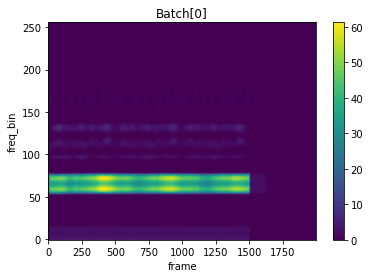

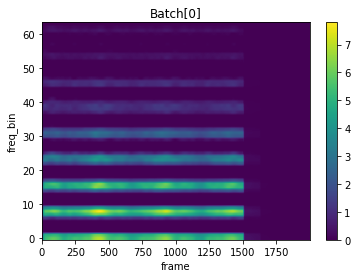

'data/nsynth-train/audio/flute_synthetic_004-044-050.wav'

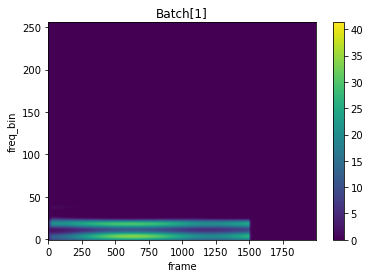

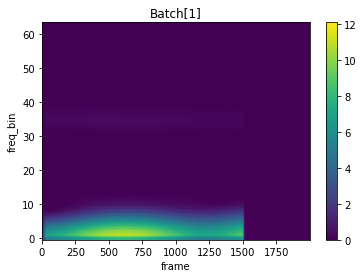

In [58]:
model = AudioIdentificationModel(1, sr=16000).to(device)
torch.cuda.empty_cache()
model.load_state_dict(torch.load('final-model-flute.pth'))

x, targets, files = next(iter(flute_train_dataloader))

model.eval()
model.reset()
with torch.no_grad():
    mel = model._melspectrogram(x, sr=sample_rate, final=True)
    
    # Show the spectrograms
    display(files[0])
    plot_spectrogram(mel[0], 'Batch[0]')
    display(Audio(x[0], rate = sample_rate))
    
    display(files[1])
    plot_spectrogram(mel[1], 'Batch[1]')
    display(Audio(x[1], rate = sample_rate))

torch.Size([2, 320, 1999])
torch.Size([2, 320, 1999])
torch.Size([320, 1999])
torch.Size([320, 320, 0])
torch.Size([320, 320, 0])


error: OpenCV(4.6.0) /io/opencv/modules/core/src/matrix.cpp:462: error: (-2:Unspecified error) in function 'cv::Mat::Mat(cv::Size, int, void*, size_t)'
>  (expected: '_step >= minstep'), where
>     '_step' is 1280
> must be greater than or equal to
>     'minstep' is 655360


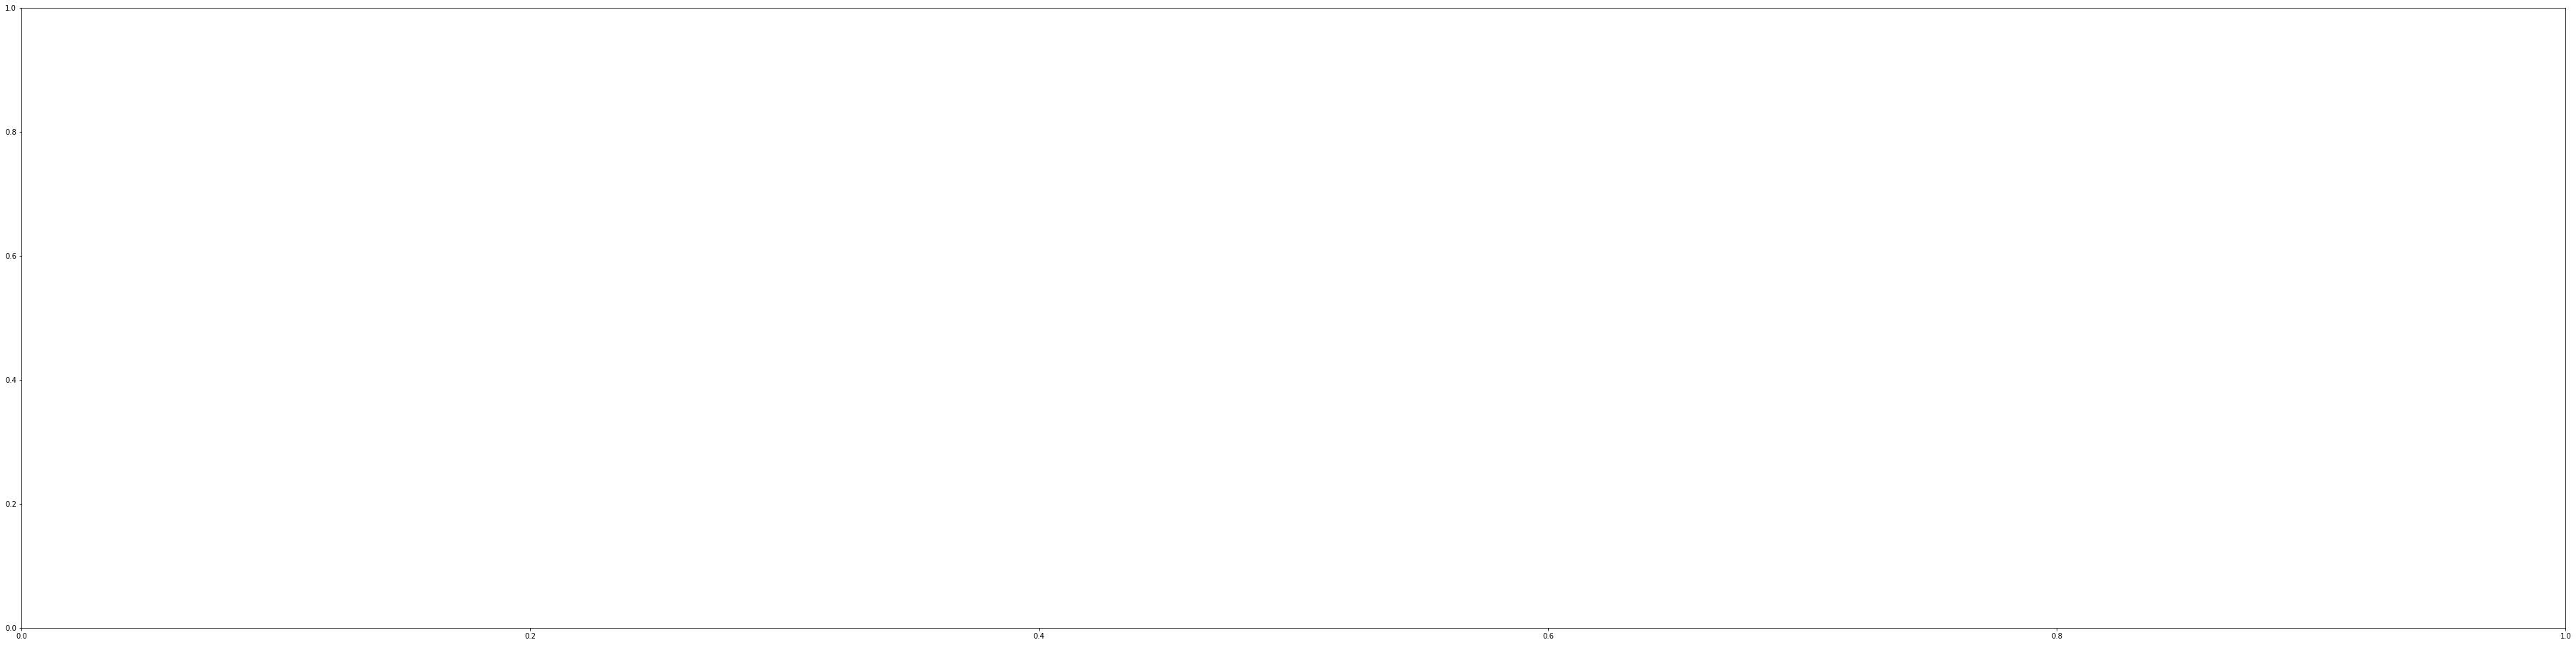

In [85]:
with torch.no_grad():
    # get the first spike
    osz = list(mel.shape)
    
    mel = mel[:2, ...]
    xbuffer = torch.zeros(tuple(mel.shape), device=device)
    print(xbuffer.shape)
    
    mel = mel.to(device)
    for i in range(mel.shape[-1]):
        xi = mel[..., i]
            
        # threshold the magnitude
        xi = model._input_spike(xi)
        xbuffer[..., i] = xi

    spikeplt = xbuffer.clone().cpu()
    print(spikeplt.shape)
    plot_spike_train(spikeplt[0], 'Batch[0]', sr=sample_rate)
    plot_spike_train(spikeplt[1], 'Batch[1]', sr=sample_rate)
